In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df=pd.read_csv("minimum_temperature.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)
df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [3]:
df.dtypes

Temp    float64
dtype: object

In [4]:
df.isna().sum()

Temp    0
dtype: int64

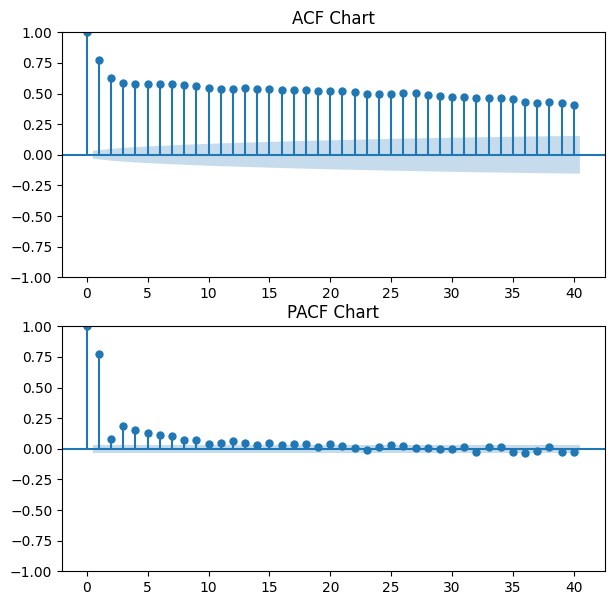

In [5]:
plt.figure(figsize = (7,7))
plt.subplot(2,1,1)
plot_acf(df['Temp'], lags = 40, ax = plt.gca(), title= "ACF Chart")
plt.subplot(2,1,2)
plot_pacf(df['Temp'], lags = 40, ax = plt.gca(), title= "PACF Chart")
plt.show()

In [6]:
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [7]:
adf_test(df["Temp"])

1. ADF :  -4.444804924611687
2. P-Value :  0.00024708263003611164
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 3629
5. Critical Values :
	 1% :  -3.4321532327220154
	 5% :  -2.862336767636517
	 10% :  -2.56719413172842


In [8]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_date = train.index
test_date = test.index

In [10]:
train_values = train.values.reshape(-1, 1)
test_values = test.values.reshape(-1, 1)

In [11]:
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

In [12]:
train_scaled = train_scaled.reshape(-1, len(train.columns))
test_scaled = test_scaled.reshape(-1, len(test.columns))

In [13]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train_date)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test_date)

In [14]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

In [15]:
sequence_length = 10
X_train = create_sequences(train_scaled_df.values, sequence_length)
X_test = create_sequences(test_scaled_df.values, sequence_length)

In [16]:
X_train, y_train = X_train[:, :-1], X_train[:, -1][:, -1]
X_test, y_test = X_test[:, :-1], X_test[:, -1][:, -1]

In [17]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
91/91 - 1s - loss: 0.0419 - val_loss: 0.0099 - 1s/epoch - 16ms/step
Epoch 2/50
91/91 - 0s - loss: 0.0111 - val_loss: 0.0091 - 328ms/epoch - 4ms/step
Epoch 3/50
91/91 - 0s - loss: 0.0108 - val_loss: 0.0090 - 373ms/epoch - 4ms/step
Epoch 4/50
91/91 - 0s - loss: 0.0106 - val_loss: 0.0088 - 357ms/epoch - 4ms/step
Epoch 5/50
91/91 - 0s - loss: 0.0104 - val_loss: 0.0086 - 362ms/epoch - 4ms/step
Epoch 6/50
91/91 - 0s - loss: 0.0102 - val_loss: 0.0082 - 373ms/epoch - 4ms/step
Epoch 7/50
91/91 - 0s - loss: 0.0099 - val_loss: 0.0080 - 336ms/epoch - 4ms/step
Epoch 8/50
91/91 - 0s - loss: 0.0096 - val_loss: 0.0080 - 322ms/epoch - 4ms/step
Epoch 9/50
91/91 - 0s - loss: 0.0094 - val_loss: 0.0083 - 371ms/epoch - 4ms/step
Epoch 10/50
91/91 - 0s - loss: 0.0092 - val_loss: 0.0074 - 366ms/epoch - 4ms/step
Epoch 11/50
91/91 - 0s - loss: 0.0092 - val_loss: 0.0076 - 375ms/epoch - 4ms/step
Epoch 12/50
91/91 - 0s - loss: 0.0091 - val_loss: 0.0075 - 373ms/epoch - 4ms/step
Epoch 13/50
91/91 - 0s - lo

In [19]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

23/23 [==============================] - 0s 2ms/step
Mean Squared Error: 0.007031424547581284
Mean Absolute Error: 0.06595846344950852


In [20]:
model.save(r"models/avg_temp_lstm_model.h5")

d:\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


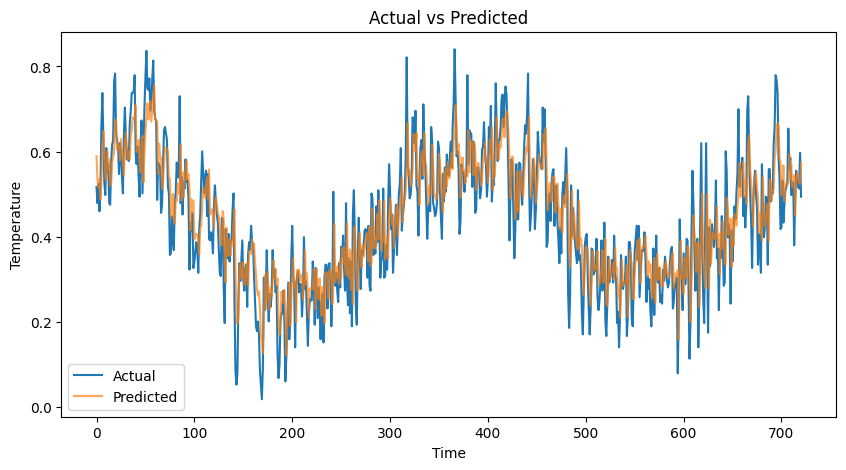

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.savefig('actual_vs_predicted.png')
plt.show()